# 1. VHM Dataset

In [35]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense

In [36]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('../Datasets/1 - VHM Historical Data.csv')
df_reversed = df.iloc[::-1].reset_index(drop=True)
df['Date'] = pd.to_datetime(df_reversed['Date'])
df1 = df_reversed['Price']
df1 = df1.str.replace(',', '').astype(float)

In [37]:
df1

0       68421.0
1       70075.0
2       68421.0
3       69022.0
4       69173.0
         ...   
1247    43350.0
1248    44200.0
1249    44400.0
1250    43400.0
1251    43950.0
Name: Price, Length: 1252, dtype: float64

In [38]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

## Ratio 9:1

In [39]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [40]:
# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [41]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [42]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(50, input_dim=100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [43]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
17/17 [==============================] - 1s 11ms/step - loss: 0.3651 - val_loss: 0.0017
Epoch 2/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0126 - val_loss: 0.0014
Epoch 3/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0065 - val_loss: 0.0012
Epoch 4/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0012
Epoch 5/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0014
Epoch 6/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0048 - val_loss: 0.0012
Epoch 7/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0043 - val_loss: 0.0011
Epoch 8/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0041 - val_loss: 9.0997e-04
Epoch 9/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 9.9243e-04
Epoch 10/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 9.9453e

In [44]:
# 9. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 19ms/step


In [45]:
# 10. Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [46]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 43198.68824233694
Testing MAPE: 536691.8036367549
Testing MAE: 43174.27789932766


In [47]:
# 12. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])
        x_input = x_input.reshape((1, n_steps))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1


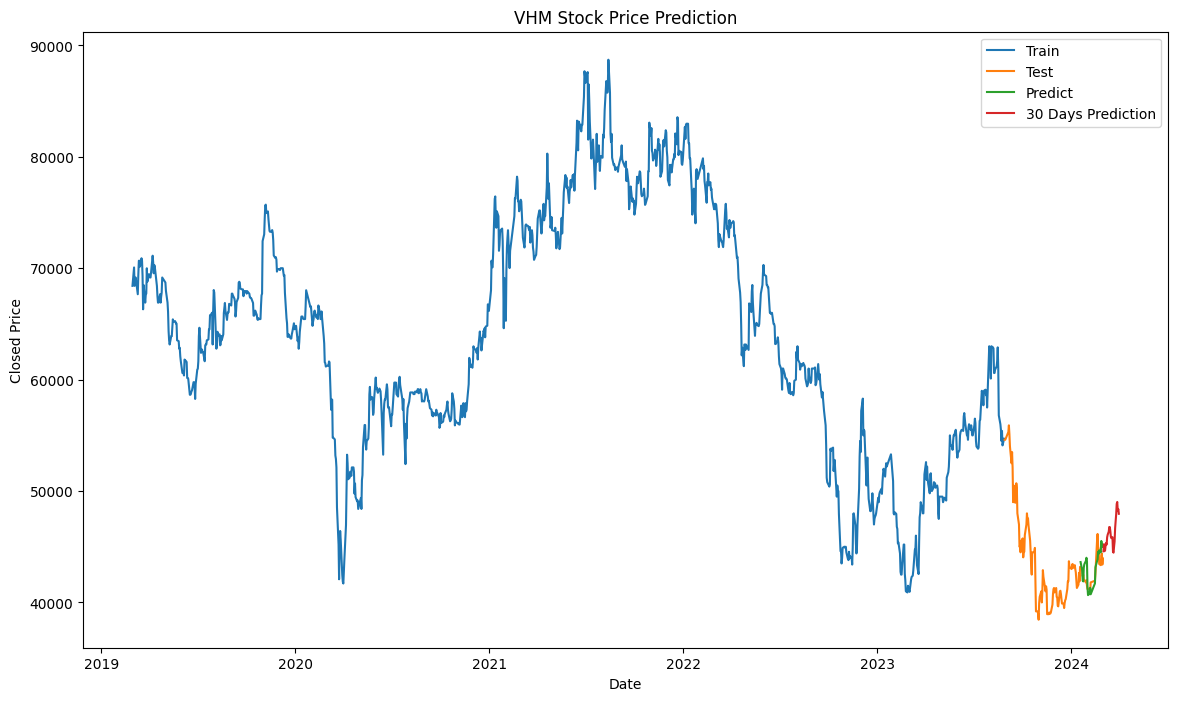

In [48]:
# 13. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df_reversed['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('VHM Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closed Price')
plt.legend()

plt.show()

## Ratio 8:2

In [49]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [50]:
# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [51]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [52]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(50, input_dim=100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [53]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
15/15 [==============================] - 1s 13ms/step - loss: 0.2622 - val_loss: 0.0172
Epoch 2/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0150 - val_loss: 0.0128
Epoch 3/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0089 - val_loss: 0.0098
Epoch 4/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0070 - val_loss: 0.0125
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0058 - val_loss: 0.0097
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0052 - val_loss: 0.0080
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0046 - val_loss: 0.0073
Epoch 8/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0042 - val_loss: 0.0067
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0070
Epoch 10/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0062
Epoch 11

In [54]:
# 9. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

5/5 [==============================] - 0s 2ms/step


In [55]:
# 10. Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [56]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 48759.99230158401
Testing MAPE: 1.2679206865299983e+18
Testing MAE: 48406.948356391236


In [57]:
# 12. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])
        x_input = x_input.reshape((1, n_steps))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1


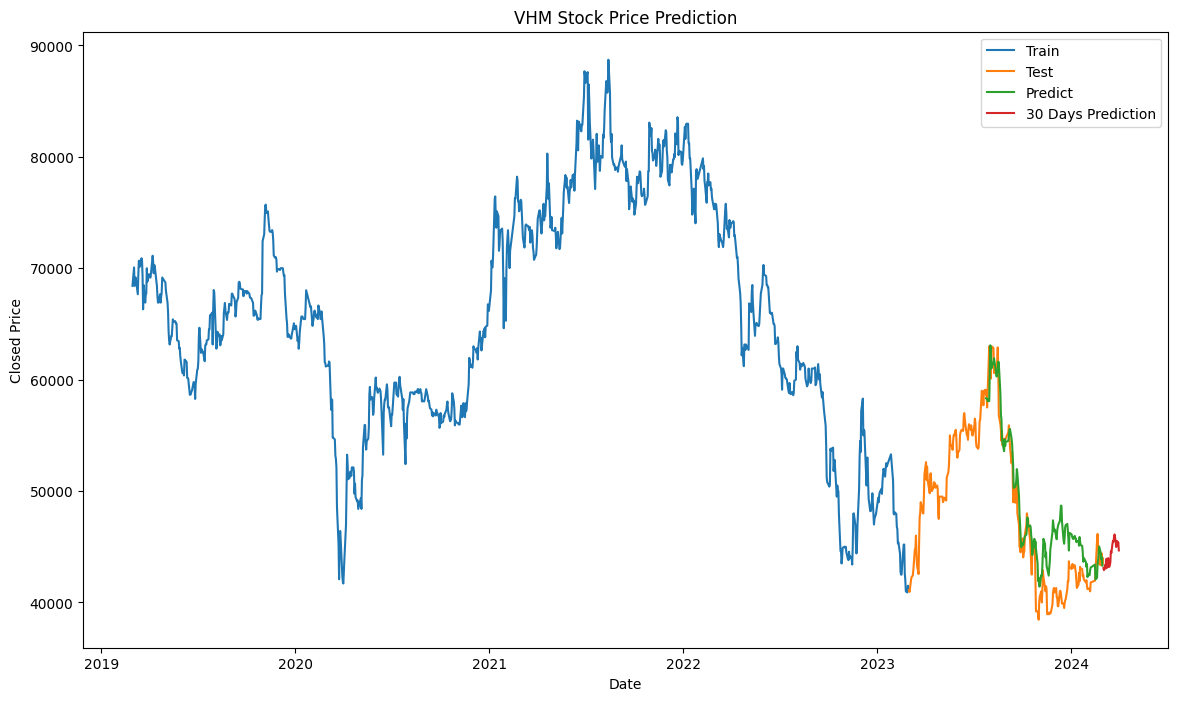

In [58]:
# 13. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df_reversed['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('VHM Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closed Price')
plt.legend()

plt.show()

## Ratio 7:3

In [59]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [60]:
# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [61]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [62]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(50, input_dim=100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [63]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
13/13 [==============================] - 1s 14ms/step - loss: 0.0959 - val_loss: 0.0204
Epoch 2/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0264 - val_loss: 0.0152
Epoch 3/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0116 - val_loss: 0.0135
Epoch 4/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0083 - val_loss: 0.0108
Epoch 5/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0062 - val_loss: 0.0081
Epoch 6/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0048 - val_loss: 0.0066
Epoch 7/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0039 - val_loss: 0.0060
Epoch 8/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0065
Epoch 9/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0059
Epoch 10/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0033 - val_loss: 0.0049
Epoch 11

In [64]:
# 9. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

9/9 [==============================] - 0s 2ms/step


In [65]:
# 10. Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [66]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 49648.61367874013
Testing MAPE: 7.136715511158431e+17
Testing MAE: 49326.44444925967


In [67]:
# 12. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])
        x_input = x_input.reshape((1, n_steps))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1


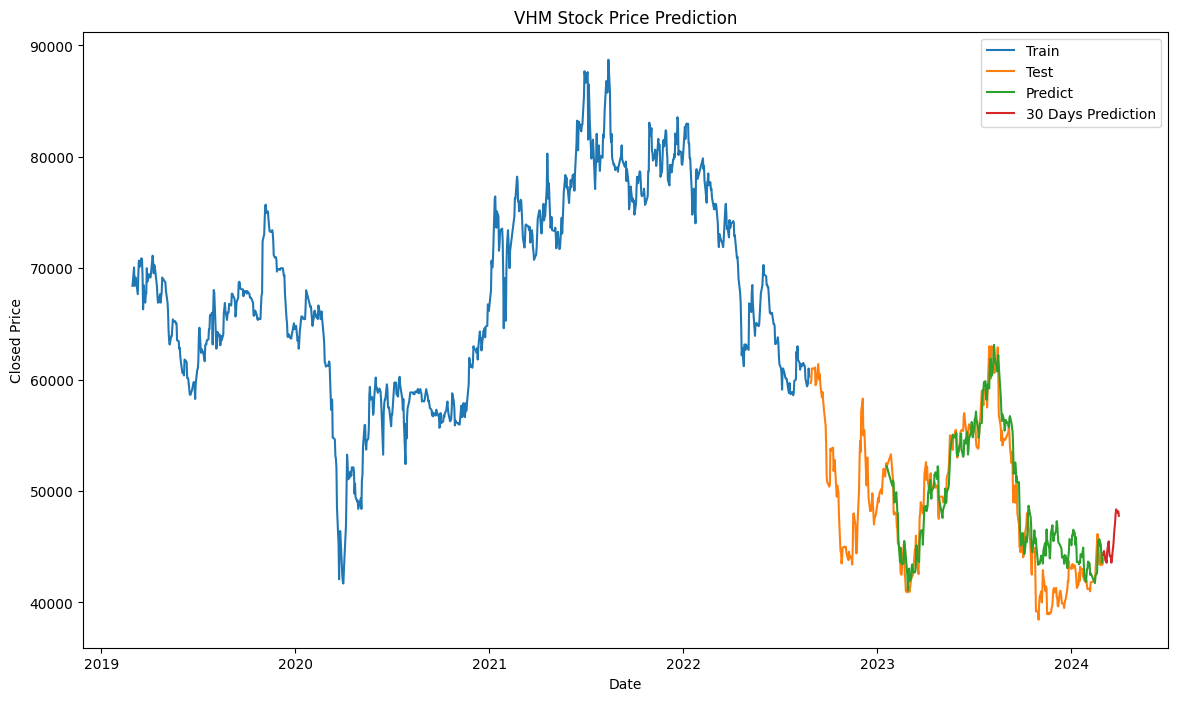

In [68]:
# 13. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df_reversed['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('VHM Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closed Price')
plt.legend()

plt.show()

# 2. NVL Dataset

In [69]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense

In [70]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('../Datasets/2 - NVL Historical Data.csv')
df_reversed = df.iloc[::-1].reset_index(drop=True)
df['Date'] = pd.to_datetime(df_reversed['Date'])
df1 = df_reversed['Price']
df1 = df1.str.replace(',', '').astype(float)

In [71]:
df1

0       32933.0
1       33100.0
2       32711.0
3       31709.0
4       31932.0
         ...   
1247    16800.0
1248    17050.0
1249    17000.0
1250    17100.0
1251    17300.0
Name: Price, Length: 1252, dtype: float64

In [72]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

## Ratio 9:1

In [73]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [74]:
# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [75]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [76]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(50, input_dim=100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [77]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
17/17 [==============================] - 1s 10ms/step - loss: 0.3170 - val_loss: 0.0012
Epoch 2/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0297 - val_loss: 3.3607e-04
Epoch 3/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0088 - val_loss: 8.6591e-05
Epoch 4/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0108 - val_loss: 7.0096e-04
Epoch 5/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 5.0904e-04
Epoch 6/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 3.4108e-04
Epoch 7/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 2.4556e-04
Epoch 8/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0026 - val_loss: 1.4420e-04
Epoch 9/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 1.1966e-04
Epoch 10/100
17/17 [==============================] - 0s 3ms/step - loss: 0.

In [78]:
# 9. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 23ms/step


In [79]:
# 10. Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [80]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 17388.508753019352
Testing MAPE: 212314.03350884092
Testing MAE: 17383.427374114817


In [81]:
# 12. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])
        x_input = x_input.reshape((1, n_steps))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1


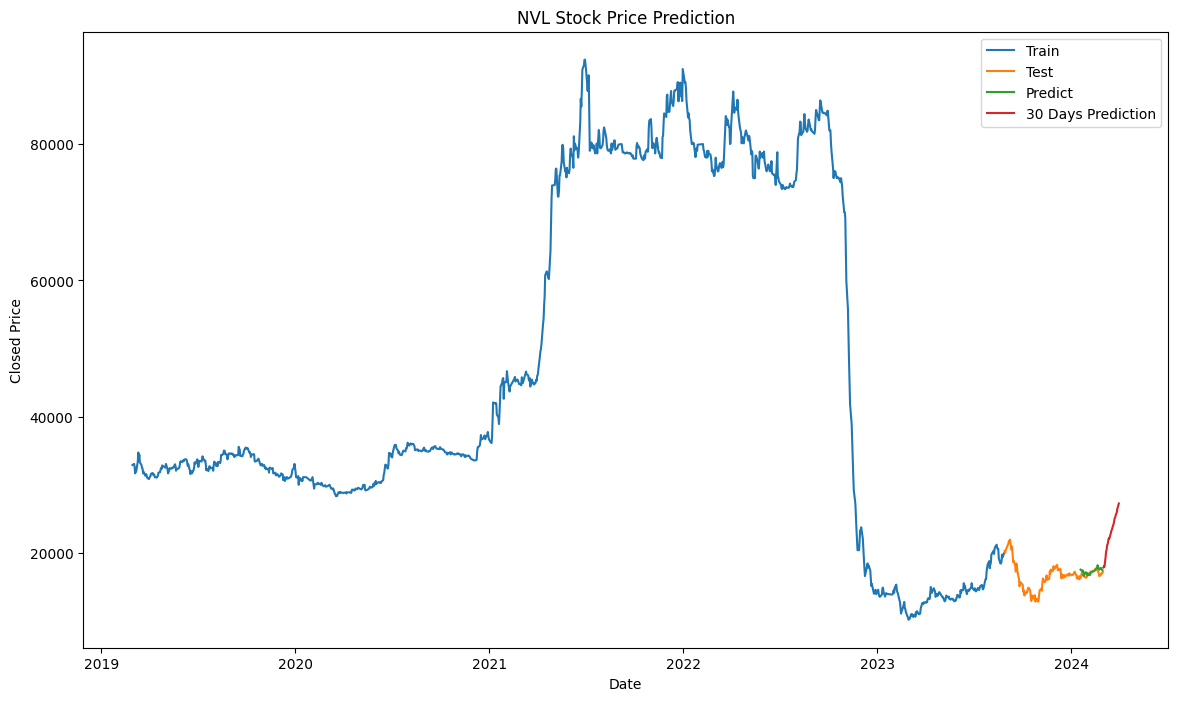

In [82]:
# 13. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df_reversed['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('NVL Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closed Price')
plt.legend()

plt.show()

## Ratio 8:2

In [83]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [84]:
# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [85]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [86]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(50, input_dim=100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [87]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
15/15 [==============================] - 1s 12ms/step - loss: 0.0707 - val_loss: 0.0024
Epoch 2/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0190 - val_loss: 0.0018
Epoch 3/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0108 - val_loss: 0.0019
Epoch 4/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0065 - val_loss: 0.0019
Epoch 5/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0056 - val_loss: 0.0018
Epoch 6/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0050 - val_loss: 0.0012
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0040 - val_loss: 0.0012
Epoch 8/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0031 - val_loss: 9.5254e-04
Epoch 9/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 9.3416e-04
Epoch 10/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 9.3248e

In [88]:
# 9. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

5/5 [==============================] - 0s 2ms/step


In [89]:
# 10. Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [90]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 17314.743320529335
Testing MAPE: 221875.03936172122
Testing MAE: 17181.76166267333


In [91]:
# 12. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])
        x_input = x_input.reshape((1, n_steps))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1


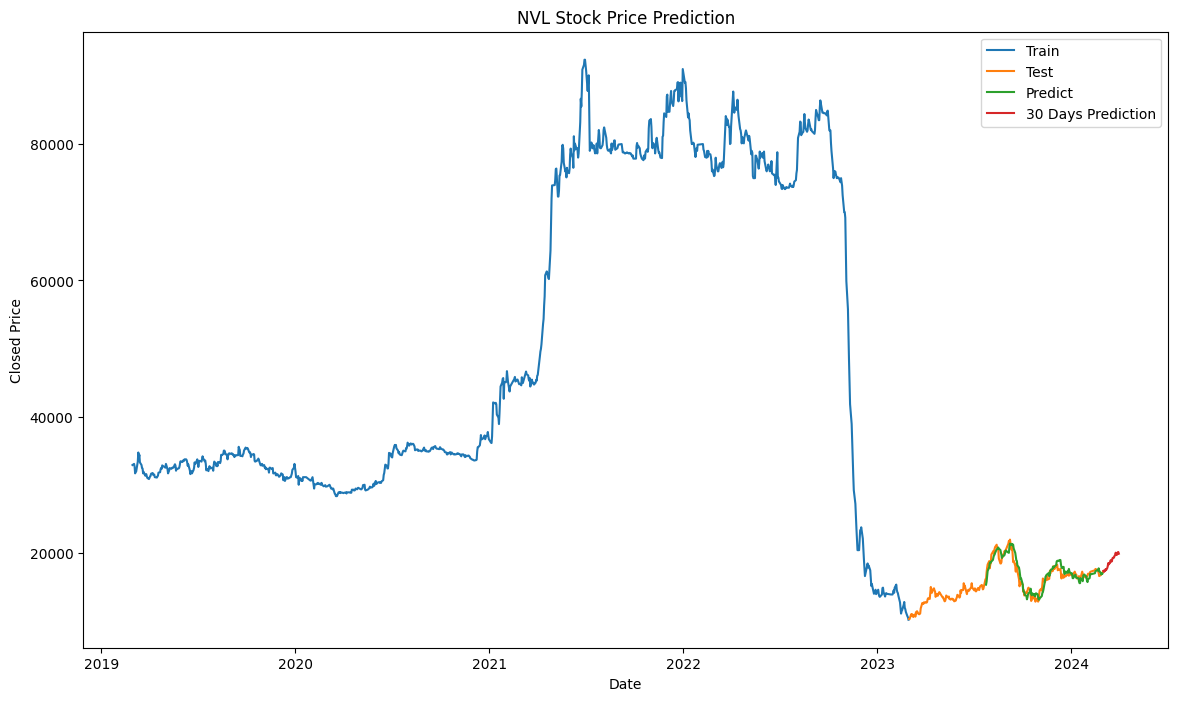

In [92]:
# 13. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df_reversed['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('NVL Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closed Price')
plt.legend()

plt.show()

## Ratio 7:3

In [93]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [94]:
# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [95]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [96]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(50, input_dim=100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [97]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
13/13 [==============================] - 1s 16ms/step - loss: 0.1246 - val_loss: 0.0113
Epoch 2/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0139 - val_loss: 0.0117
Epoch 3/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0062 - val_loss: 0.0090
Epoch 4/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0107
Epoch 5/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0037 - val_loss: 0.0109
Epoch 6/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0034 - val_loss: 0.0099
Epoch 7/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0032 - val_loss: 0.0103
Epoch 8/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0113
Epoch 9/100
13/13 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0112
Epoch 10/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0111
Epoch 11

In [98]:
# 9. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

9/9 [==============================] - 0s 2ms/step


In [99]:
# 10. Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [100]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 21874.965231388553
Testing MAPE: 6.13617624263981e+17
Testing MAE: 20437.389772735576


In [101]:
# 12. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])
        x_input = x_input.reshape((1, n_steps))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1


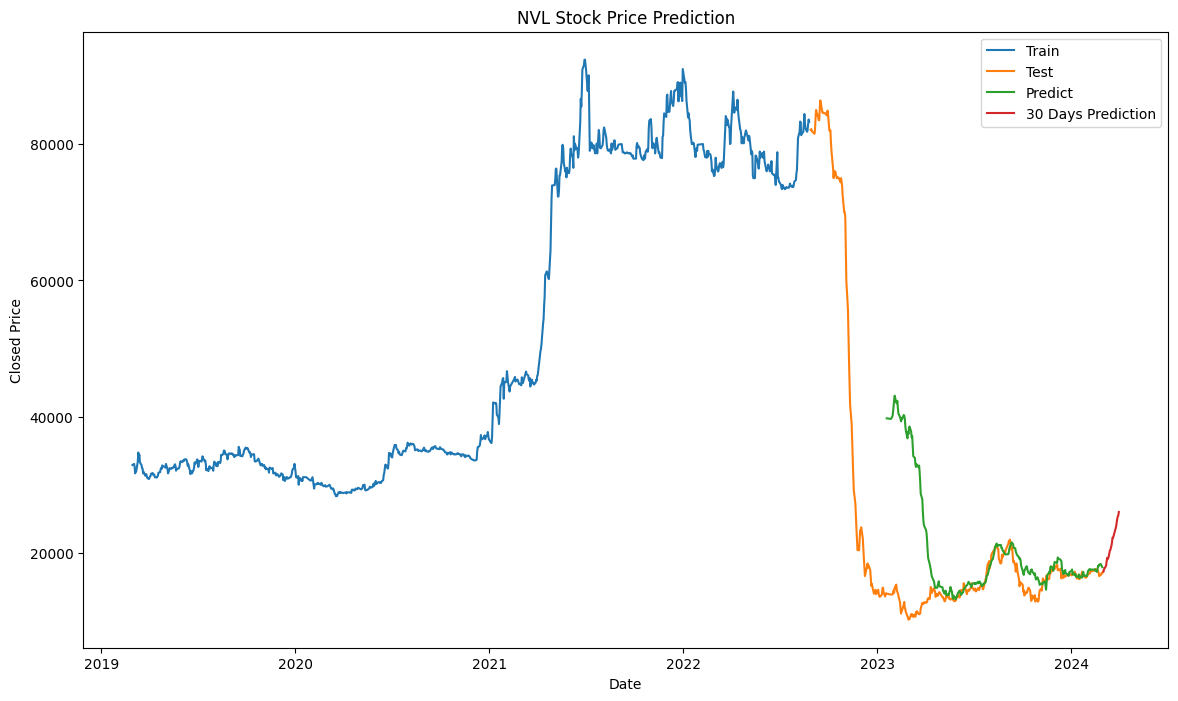

In [102]:
# 13. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df_reversed['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('NVL Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closed Price')
plt.legend()

plt.show()

# 3. NLG Dataset

In [103]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense

In [104]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('../Datasets/3 - NLG Historical Data.csv')
df_reversed = df.iloc[::-1].reset_index(drop=True)
df['Date'] = pd.to_datetime(df_reversed['Date'])
df1 = df_reversed['Price']
df1 = df1.str.replace(',', '').astype(float)

In [105]:
df1

0       18706.8
1       19127.2
2       18917.0
3       18846.9
4       18706.8
         ...   
1247    37400.0
1248    38500.0
1249    38200.0
1250    39600.0
1251    39900.0
Name: Price, Length: 1252, dtype: float64

In [106]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

## Ratio 9:1

In [107]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [108]:
# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [109]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [110]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(50, input_dim=100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [111]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
17/17 [==============================] - 1s 10ms/step - loss: 0.1684 - val_loss: 0.0014
Epoch 2/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0126 - val_loss: 0.0045
Epoch 3/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0086 - val_loss: 9.0622e-04
Epoch 4/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0061 - val_loss: 9.3846e-04
Epoch 5/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 0.0014
Epoch 6/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0011
Epoch 7/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 7.4218e-04
Epoch 8/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 7.7225e-04
Epoch 9/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 8.0353e-04
Epoch 10/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0023 - val_l

In [112]:
# 9. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 28ms/step


In [113]:
# 10. Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [114]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 37670.45271999881
Testing MAPE: 75769.8341141358
Testing MAE: 37663.89518407785


In [115]:
# 12. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])
        x_input = x_input.reshape((1, n_steps))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1


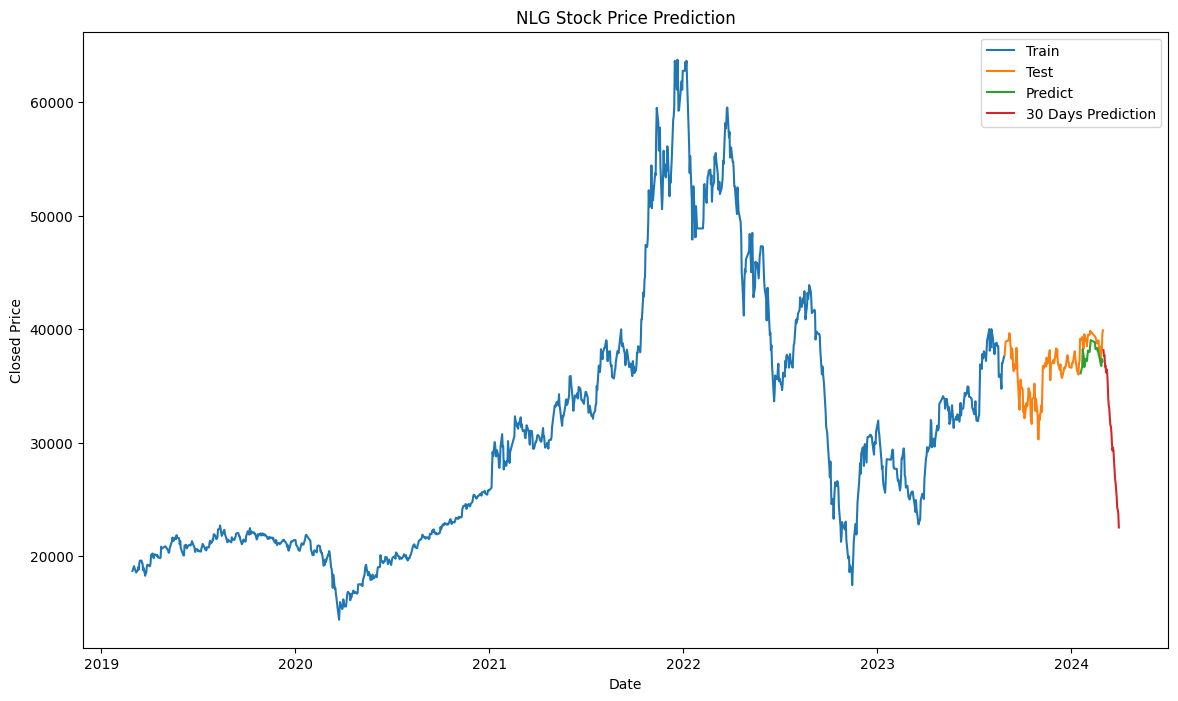

In [116]:
# 13. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df_reversed['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('NLG Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closed Price')
plt.legend()

plt.show()

## Ratio 8:2

In [117]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [118]:
# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [119]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [120]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(50, input_dim=100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [121]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
15/15 [==============================] - 1s 13ms/step - loss: 0.0365 - val_loss: 0.0126
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0076 - val_loss: 0.0072
Epoch 3/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0063 - val_loss: 0.0029
Epoch 4/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0018
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 6/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 7/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 8/100
15/15 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 9/100
15/15 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 10/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 1

In [122]:
# 9. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

5/5 [==============================] - 0s 2ms/step


In [123]:
# 10. Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [124]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 36232.38532703699
Testing MAPE: 80156.53735151836
Testing MAE: 36159.499685566785


In [125]:
# 12. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])
        x_input = x_input.reshape((1, n_steps))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1


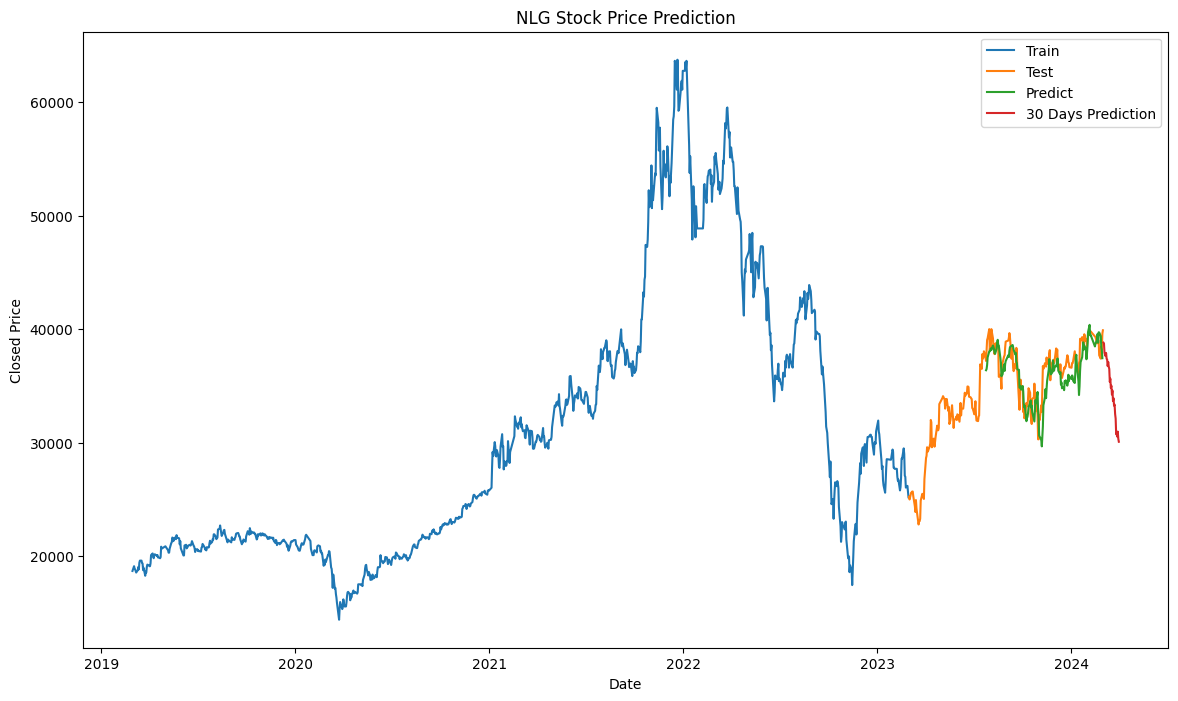

In [126]:
# 13. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df_reversed['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('NLG Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closed Price')
plt.legend()

plt.show()

## Ratio 7:3

In [127]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [128]:
# 5. Hàm Create Dataset
import numpy

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [129]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)


In [130]:
# 7. Define MLP Model
model = Sequential()
model.add(Dense(50, input_dim=100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [131]:
# 8. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
13/13 [==============================] - 1s 16ms/step - loss: 0.0743 - val_loss: 0.0117
Epoch 2/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0154 - val_loss: 0.0080
Epoch 3/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0093 - val_loss: 0.0056
Epoch 4/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0060 - val_loss: 0.0043
Epoch 5/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0046 - val_loss: 0.0039
Epoch 6/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 7/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0037 - val_loss: 0.0028
Epoch 8/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 9/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 10/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 11

In [132]:
# 9. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

9/9 [==============================] - 0s 2ms/step


In [133]:
# 10. Chuẩn hóa dữ liệu y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [134]:
# 11. Đánh giá độ chính xác thuật toán bằng RMSE và các độ đo khác
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)

print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)


Testing RMSE: 34222.59130591102
Testing MAPE: 88942.51707115816
Testing MAE: 33929.942769453366


In [135]:
# 12. Dự báo 30 ngày tiếp theo
x_input = test_data[-100:].reshape(1, -1)
temp_input = x_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while i < 30:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[-100:])
        x_input = x_input.reshape((1, n_steps))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1


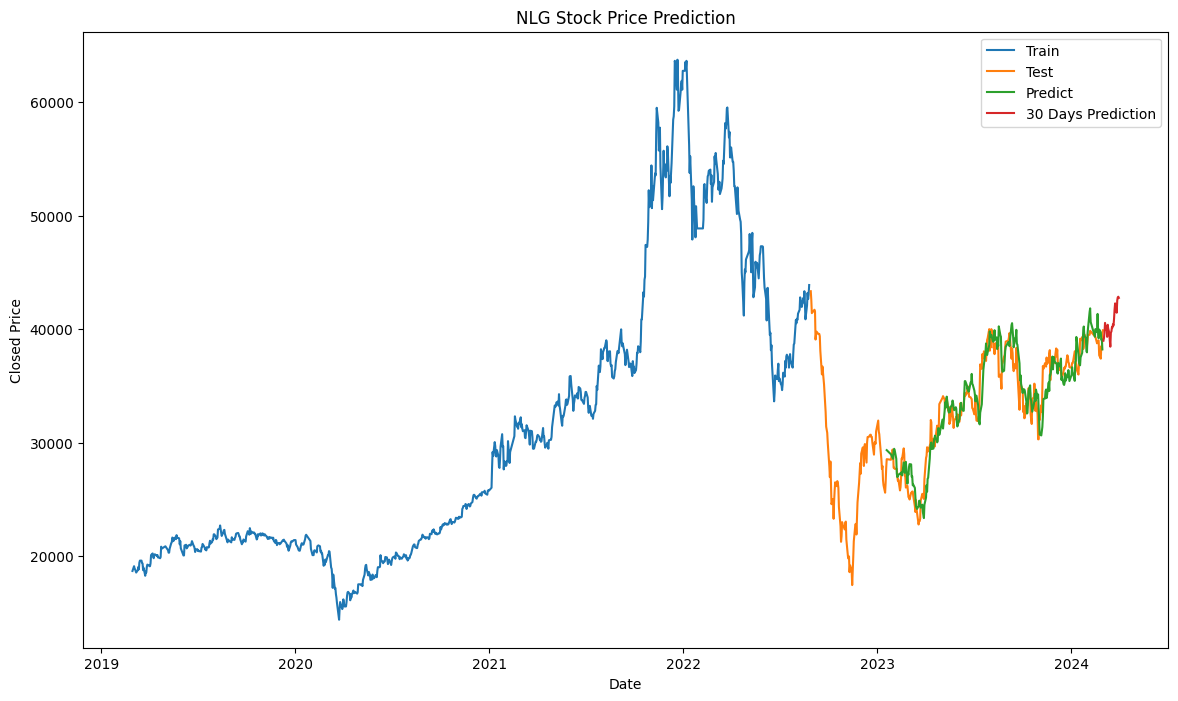

In [136]:
# 13. Vẽ hình
plt.figure(figsize=(14, 8))
dates = pd.to_datetime(df_reversed['Date'])

plt.plot(dates[:train_size], scaler.inverse_transform(train_data), label='Train')
plt.plot(dates[train_size:], scaler.inverse_transform(test_data), label='Test')
predicted_test_index_start = train_size + time_step
plt.plot(dates[predicted_test_index_start:predicted_test_index_start + len(y_pred)], y_pred, label='Predict')
future_dates = pd.date_range(start=dates.iloc[-1], periods=31, inclusive='right')
plt.plot(future_dates, scaler.inverse_transform(lst_output), label='30 Days Prediction')

plt.title('NLG Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Closed Price')
plt.legend()

plt.show()